<a href="https://colab.research.google.com/github/StillWork/colab-1/blob/master/f_11_time_series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 시계열 분석
- 온도, 습도, 기압, 풍향 등 14개 데이터 사용, 10분마다 기록
- 며칠간의 데이터를 입력하고 24시간 이후의 기온 예측

## 드롭아웃, 스태킹, 양방향 순환신경망 사용
- 순환 드롭아웃: 과대적합을 방지
- 스태킹 순환 층: 네트워크의 표현능력을 향상(계산량은 늘어난다)
- 양방향 순환 층: 서로 다른 방향으로 데이터를 입력하여 정확도를 높이고 기억을 오랫동안 유지  

## 데이터
- 독일 Jena시 막스 프랑크 생물지구화학연구소에서 지상 관측소에서 측정한 데이터 
- 2009~2016년 데이터 사용

Let's take a look at the data:

In [0]:
import os, os.path, shutil
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
if not os.path.exists("./data"):
    os.makedirs("./data")
if not os.path.exists("./data/jena_climate.zip"):
  !wget --no-check-certificate \
    https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip \
    -O ./data/jena_climate.zip

--2018-12-06 12:21:23--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘./data/jena_climate.zip’

./data/jena_climate 100%[===================>]  12.94M  16.4MB/s    in 0.8s    

2018-12-06 12:21:25 (16.4 MB/s) - ‘./data/jena_climate.zip’ saved [13568290/13568290]



In [0]:
local_zip = './data/jena_climate.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data')
zip_ref.close()

In [0]:
!ls data

jena_climate_2009_2016.csv  jena_climate.zip


In [0]:
import os

data_dir = './data'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print("데이터 사이즈: ",len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
데이터 사이즈:  420551


In [0]:
type(lines)

list

In [0]:
lines[:3]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [0]:
type(float_data)

numpy.ndarray

In [0]:
float_data[:3]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02]])

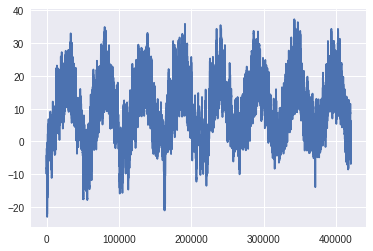

In [0]:
temp = float_data[:, 1]  # 기온만 그려본다
plt.plot(range(len(temp)), temp)
plt.show()

### 10일간 데이터
- 샘플은 10분마다 측정
- 스케일링 필요 (데이터 속성이 다름)
- 하루에 140번 측정

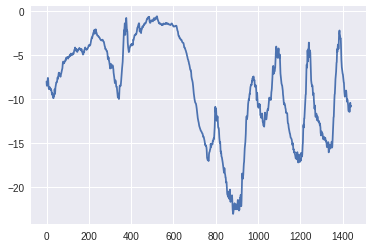

In [0]:
plt.plot(range(1440), temp[:1440])
plt.show()

## 파라미터 준비


* `lookback = 720`, 5일간 데이터를 관찰.
* `steps = 6`, 1시간마다 한번 샘플링.
* `delay = 144`, 24시간 후를 예측.

### 준비할 사항

- 데이터 변환 (스케일링): 20만개 훈련 샘플을 사용하여 평균과 표준편차를 계산한다.
- 데이터가 수치형이므로 벡터화는 사용하지 않는다
- 입력 데이터와 레이블을 공급하기 위한 제너레이터를 작성



In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

제너레이터를 (samples, targets) 형태의 값을 생성한다.  sample은 입력의 한 배치를 나타낸다.

제너레이터를 사용하는 이유는 입력 데이터를 모두 한번에 메모리에 미리 로드하지 않기 위해서이다.

아래는 제너레이터 함수의 인자이다:

* `data`: 스케링된 입력 데이터
* `lookback`: 과거의 몇개의 타임스텝을 사용할지 지정
* `delay`: 미래 몇 타임스텝후를 예측할지
* `min_index` and `max_index`: 검증 및 테스트 데이터를 구분하는 경계를 표시
* `shuffle`: 샘플들은 랜덤하게 취할지를 지정
* `batch_size`: 배치 크기
* `step`: 샘플 데이터를 취할 타임스텝수 (여기서는 6)

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

훈련 데이터는 처음 20만개, 검증 데이터는 다음 10만개, 나머지는 테스트 데이터로 사용한다.
SGD를 사용하면 과적합을 피하고, 최적값을 찾아낸 확률이 높아진다.

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 기본 성능 모델

평균치 예측 등, 가장 기본적인 성능을 내는, 최소 기준의 모델을 말한다. 기계학습을 사용하면 적어도 이보다는 성능이 좋아야 한다.
  
여기서는 내일의 날씨는 오늘과 같다고 단순히 예측하는 모델을 사용하겠다. 성능 평가로 절대값 오차를 사용(MAE). 

In [0]:
np.mean(np.abs(preds - targets))

- 아래에 기본 성능 모델의 성능을 계산하였다.

In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


오차 값 0.29는 정규화 한 값이므로 표준 편차를 곱하여 온도의 오차를 구할 수 있다. 온도의 평균 오차는  
2.57˚C이다. 

## 먼저 간단한 신경망 모델 만들기

- RNN과 같은 복잡한 모데을 처음부터 만들지 말고, 우선 간단한 신경망으로 동작을 확인해 보는 것이 필요하다.'

- 여기서는 두개의 전결합망으로 구성된 MLP을 먼저 만들어보겠다. 성능평가는 MAE를 사용한다.회귀문제이므로 마지막 단은 활성화함수를 사용하지 않는다.

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s - loss: 1.5009 - val_loss: 0.4131
Epoch 2/20
500/500 [==============================] - 10s - loss: 0.4272 - val_loss: 0.2994
Epoch 3/20
500/500 [==============================] - 9s - loss: 0.2837 - val_loss: 0.3115
Epoch 4/20
500/500 [==============================] - 9s - loss: 0.2629 - val_loss: 0.3213
Epoch 5/20
500/500 [==============================] - 9s - loss: 0.2486 - val_loss: 0.3156
Epoch 6/20
500/500 [==============================] - 9s - loss: 0.2405 - val_loss: 0.3144
Epoch 7/20
500/500 [==============================] - 9s - loss: 0.2351 - val_loss: 0.3165
Epoch 8/20
500/500 [==============================] - 9s - loss: 0.2289 - val_loss: 0.3151
Epoch 9/20
500/500 [==============================] - 9s - loss: 0.2248 - val_loss: 0.3238
Epoch 10/20
500/500 [==============================] - 9s - loss: 0.2215 - val_loss: 0.3442
Epoch 11/20
500/500 [==============================] - 9s - loss: 0.2161 - val_loss: 0.

훈련과 검증 데이터에 대해서 손실함수 그래프를 그려보겠다.

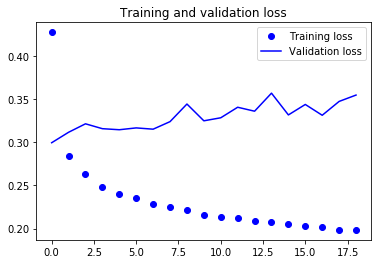

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

앞에서 구한 기본성능 0.29을 얻는 것도 쉽지 않다. 모델로 복잡한 구조를 사용했다고 해서 간단한, 상식적인 모델보다 우수한 성능을 내는 것은 아니다. 모델이 이러한 답을 바로 찾을 수 있다는 보장은 없다. (사람의 직관에 의한 기본 성능을 내는 것도 컴퓨터에게는 어려울 수 있다.)

## 간단한 RNN 모델

앞의 MLP는 시간 정보를 활용하지 못하고 있다. 시퀀스 데이터를 그대로 사용하고 이를 반영하는 모델을 만들어야 한다. 

LSTM을 간략히 구현하는 방식인 GRU(gated recurrent unit)을 사용하겠다.

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 169s - loss: 0.3216 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 168s - loss: 0.2846 - val_loss: 0.2654
Epoch 3/20
500/500 [==============================] - 168s - loss: 0.2772 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 168s - loss: 0.2707 - val_loss: 0.2663
Epoch 5/20
500/500 [==============================] - 168s - loss: 0.2643 - val_loss: 0.2680
Epoch 6/20
500/500 [==============================] - 169s - loss: 0.2584 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 168s - loss: 0.2553 - val_loss: 0.2658
Epoch 8/20
500/500 [==============================] - 168s - loss: 0.2508 - val_loss: 0.2672
Epoch 9/20
500/500 [==============================] - 165s - loss: 0.2455 - val_loss: 0.2728
Epoch 10/20
500/500 [==============================] - 164s - loss: 0.2423 - val_loss: 0.2801
Epoch 11/20
500/500 [==============================] - 164s - loss: 0

아래 결과를 보면 성능이 나아졌다.

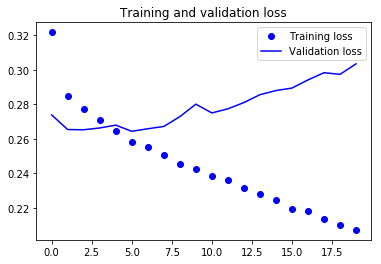

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

MAE 성능이 0.265 정도로 조금 개선되었다.(2.35˚C)  - 기본 모델의 성능이 2.57˚C 였다.

## 과대적합 줄이기

몇 번의 이포크 후에 성능이 바빠지므로 과대적합된 것을 알 수 있다. 오랫동안 순환층 이전에 드롭아웃을 사용하면 학습에 방해가 된다고 알려졌다. 타임 스텝마다 랜덤하게 드롭아웃 패턴을 바꾸지 않고, 동일한 패턴을 모든 타임 스텝에 적용해야 한다. 드롭아웃을 사용하면 학습시간이 오래걸린다.


In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 171s - loss: 0.3526 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 170s - loss: 0.3138 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 170s - loss: 0.3033 - val_loss: 0.2694
Epoch 5/40
500/500 [==============================] - 170s - loss: 0.3006 - val_loss: 0.2695
Epoch 6/40
500/500 [==============================] - 170s - loss: 0.2990 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 170s - loss: 0.2955 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 170s - loss: 0.2942 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 171s - loss: 0.2940 - val_loss: 0.2649
Epoch 10/40
500/500 [==============================] - 170s - loss: 0.2923 - val_loss: 0.2673
Epoch 11/40
500/500 [==============================] - 170s - loss: 0

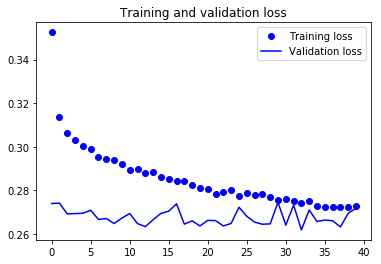

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

과대적합이 발생하지 않았다. 성능은 별로 개선되지는 않았다.

## 순환망 쌓기 (Stacking)

이제 과대적합이 되기 전까지는 네트워크의 복잡도(용량)을 늘려서 성능을 개선할 수 있다. 스태킹을 하려면 중간 계층에서는 시퀀스 전체를 출력해야 한다. 이를 위해서 return_sequences=True 로 설정해야 한다.

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 346s - loss: 0.3341 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 344s - loss: 0.3125 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 344s - loss: 0.3045 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 344s - loss: 0.3018 - val_loss: 0.2747
Epoch 5/40
500/500 [==============================] - 344s - loss: 0.2957 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 344s - loss: 0.2923 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 344s - loss: 0.2907 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 343s - loss: 0.2879 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 343s - loss: 0.2866 - val_loss: 0.2743
Epoch 10/40
500/500 [==============================] - 344s - loss: 0.2833 - val_loss: 0.2669
Epoch 11/40
500/500 [==============================] - 344s - loss: 0

성능을 보겠다.

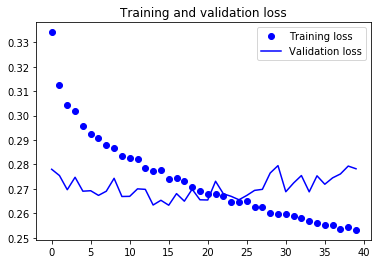

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가해도 성능이 크게 향상되지 않는 것을 알 수 있다.

## Using bidirectional RNNs


The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which 
can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it 
the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or 
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason 
why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits 
the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, 
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By 
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may 
have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have 
performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try 
this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted 
along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we 
used in the first experiment in this section, we get the following results:

In [0]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 172s - loss: 0.4781 - val_loss: 0.4797
Epoch 2/20
500/500 [==============================] - 171s - loss: 0.4529 - val_loss: 0.4679
Epoch 3/20
500/500 [==============================] - 170s - loss: 0.4071 - val_loss: 0.4536
Epoch 4/20
500/500 [==============================] - 171s - loss: 0.3670 - val_loss: 0.4398
Epoch 5/20
500/500 [==============================] - 170s - loss: 0.3343 - val_loss: 0.4320
Epoch 6/20
500/500 [==============================] - 170s - loss: 0.3191 - val_loss: 0.4388
Epoch 7/20
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.4186
Epoch 8/20
500/500 [==============================] - 170s - loss: 0.2938 - val_loss: 0.4014
Epoch 9/20
500/500 [==============================] - 170s - loss: 0.2824 - val_loss: 0.4077
Epoch 10/20
500/500 [==============================] - 170s - loss: 0.2724 - val_loss: 0.4090
Epoch 11/20
500/500 [==============================] - 170s - loss: 0

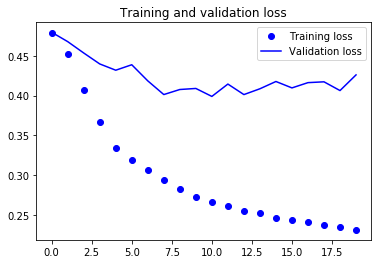

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very 
important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the 
recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our 
problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is 
bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural 
language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's 
try the same trick on the LSTM IMDB example from the previous section:

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 111s - loss: 0.4965 - acc: 0.7648 - val_loss: 0.3593 - val_acc: 0.8570
Epoch 2/10
20000/20000 [==============================] - 107s - loss: 0.3105 - acc: 0.8810 - val_loss: 0.3329 - val_acc: 0.8648
Epoch 3/10
20000/20000 [==============================] - 105s - loss: 0.2566 - acc: 0.9057 - val_loss: 0.3863 - val_acc: 0.8770
Epoch 4/10
20000/20000 [==============================] - 106s - loss: 0.2231 - acc: 0.9195 - val_loss: 0.3471 - val_acc: 0.8556
Epoch 5/10
20000/20000 [==============================] - 105s - loss: 0.1912 - acc: 0.9314 - val_loss: 0.3346 - val_acc: 0.8694
Epoch 6/10
20000/20000 [==============================] - 105s - loss: 0.1721 - acc: 0.9379 - val_loss: 0.3621 - val_acc: 0.8520
Epoch 7/10
20000/20000 [==============================] - 105s - loss: 0.1613 - acc: 0.9427 - val_loss: 0.3438 - val_acc: 0.8694
Epoch 8/10
20000/20000 [========================


We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our 
hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained 
on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would 
have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and 
you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the 
more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other 
approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will 
introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both 
ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer 
instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the 
input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the 
IMDB sentiment analysis task:

In [0]:
from keras import backend as K
K.clear_session()

In [0]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 214s - loss: 0.5994 - acc: 0.6865 - val_loss: 0.4722 - val_acc: 0.8090
Epoch 2/10
20000/20000 [==============================] - 213s - loss: 0.3673 - acc: 0.8543 - val_loss: 0.3769 - val_acc: 0.8448
Epoch 3/10
20000/20000 [==============================] - 213s - loss: 0.2743 - acc: 0.8972 - val_loss: 0.3196 - val_acc: 0.8688
Epoch 4/10
20000/20000 [==============================] - 211s - loss: 0.2310 - acc: 0.9150 - val_loss: 0.2972 - val_acc: 0.8856
Epoch 5/10
20000/20000 [==============================] - 211s - loss: 0.2009 - acc: 0.9261 - val_loss: 0.4461 - val_acc: 0.8514
Epoch 6/10
20000/20000 [==============================] - 210s - loss: 0.1912 - acc: 0.9339 - val_loss: 0.3636 - val_acc: 0.8640
Epoch 7/10
20000/20000 [==============================] - 209s - loss: 0.1670 - acc: 0.9423 - val_loss: 0.3476 - val_acc: 0.8580
Epoch 8/10
20000/20000 [========================

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to 
overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some 
regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 325s - loss: 0.3029 - val_loss: 0.2660
Epoch 2/40
500/500 [==============================] - 324s - loss: 0.2751 - val_loss: 0.2660
Epoch 3/40
500/500 [==============================] - 326s - loss: 0.2668 - val_loss: 0.2628
Epoch 4/40
500/500 [==============================] - 326s - loss: 0.2594 - val_loss: 0.2615
Epoch 5/40
500/500 [==============================] - 324s - loss: 0.2532 - val_loss: 0.2684
Epoch 6/40
500/500 [==============================] - 324s - loss: 0.2442 - val_loss: 0.2674
Epoch 7/40
500/500 [==============================] - 324s - loss: 0.2405 - val_loss: 0.2700
Epoch 8/40
500/500 [==============================] - 324s - loss: 0.2343 - val_loss: 0.2782
Epoch 9/40
500/500 [==============================] - 324s - loss: 0.2293 - val_loss: 0.2778
Epoch 10/40
500/500 [==============================] - 324s - loss: 0.2233 - val_loss: 0.2813
Epoch 11/40
500/500 [==============================] - 324s - loss: 0


It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the 
chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because 
the recent past matters much more than the distant past in this case).


## Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a 
given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is 
currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.


## Wrapping up

Here's what you should take away from this section:

* As you first learned in Chapter 4, when approaching a new problem, 
it is good to first establish common sense baselines for your metric of choice. If you don't have a 
baseline to beat, you can't tell if you are making any real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal 
data.
* To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras 
recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. 
While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not 
be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be 
especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will 
leave them for future study outside of this book.